- Brightness, Contrast Augmentation 에 문제가 있는듯 
- 이 코드 제너레이터 shuffle 확인 
- 50 epochs으로 학습 완료 안됨 -> 여기 1fold, 2fold만 각각 위 수정사항 적용 해서 100에폭 정도 시행 
- Augmentation -> crop 으로 수정 

# 디렉토리 설정 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/DataSet/KYR_B_imaging.zip
!cp '/content/drive/MyDrive/Colab Notebooks/Repositary/MRI_classification/utils/init.py' ./

In [ ]:
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr3' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr2 74' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr5' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr1' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr7' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr8' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr4' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/nswr1' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr6' '/content/KYR_B_imaging' 
!rm -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱'

# 초기작업
- 데이터 제너레이터에 넣을 수 있는 기본형태를 만드는 것 

## 기본 DF 생성 
- csv 데이터인 snsb_df 
- 이미지 디렉토리 관련인 dir_df만듬 

전처리 과정에서 
- snsb_df -> csvs 
- dir_df -> new_dir_df로 변환 함 


In [1]:
import os 
import cv2 
import pandas as pd 
from glob import glob
from tqdm import tqdm
from init import init #초기 설정용 커스텀 패키지 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.pyplot as cm 
import warnings
warnings.filterwarnings('ignore')
from albumentations import (
    Rotate,Compose, HorizontalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma,
    ToFloat, ShiftScaleRotate,JpegCompression
)

###snsb_df 생성 
- 환자 정보 데이터 프레임 

In [2]:
columns = ['성명',
 '병록번호',
 '만나이',
 '검사일',
 '교육년수',
 'SVLT_recall_total_score_z',
 'SVLT_Delayed_recall_z',
 'SVLT_recognition_score_z',
 'RCFT_immediate_recall_z',
 'RCFT_delayed_recall_z',
 'RCFT_recognition_score_z',
 'K_MMSE_total_score_z',
 'SNSB_II_Domain_Attention_z',
 'SNSB_II_Domain_Language_z',
 'SNSB_II_Domain_Visuospatial_z',
 'SNSB_II_Domain_Memory_z',
 'SNSB_II_Domain_Frontal_z']

snsb_df = pd.read_csv('/content/drive/MyDrive/DataSet/202202_김예림/SNSB_integerated.csv')
snsb_df = snsb_df.drop([2098,2591]) #병록번호 없는 행 제거 <- 결측치 
snsb_df['병록번호'] = snsb_df['병록번호'].apply(lambda x : str(int(x))) #소수점으로 되어 있는 것 처리하고 str형 변형 

snsb_df = snsb_df[columns]

## 결측치 처리 

#컬럼 중 isnull 검색 
#검색한 표본들의 평균 나이 
#평균 나이로 원래  csvs 검색 
#해당 나이로 검색 된 것들의 평균 값으로 insull 채움 

null_columns = ['RCFT_immediate_recall_z',
                'SVLT_recall_total_score_z',
                'SVLT_Delayed_recall_z',
                'SVLT_recognition_score_z',
'RCFT_delayed_recall_z',            
'RCFT_recognition_score_z',        
'K_MMSE_total_score_z',           
'SNSB_II_Domain_Attention_z',       
'SNSB_II_Domain_Language_z',        
'SNSB_II_Domain_Visuospatial_z',    
'SNSB_II_Domain_Memory_z',          
'SNSB_II_Domain_Frontal_z']         

for null_column in null_columns:
  try:
    null_age = int(np.mean(snsb_df[snsb_df[null_column].isnull()]['만나이']))
    null_value = np.mean(snsb_df[snsb_df['만나이']==null_age][null_column].dropna())
    snsb_df.loc[snsb_df[null_column].isnull(),null_column] = null_value
  except:
    pass

###dir_df 생성 
- 환자  별 mri 디렉토리 데이터 프레임 
- 이미지 장수 정리 안된 데이터 프레임 

In [3]:
#폴더 디렉토리
folder_dir = glob('/content/KYR_B_imaging/*')
dir_df = init.dir_df(folder_dir)
dir_df = dir_df.sort_values(by=['key','dir'])
dir_df = dir_df.reset_index().drop(columns = 'index')

### 병록번호- key 값 보정
- 병록번호 == key 하게 만들어야 함 -> primary key 
- 중복 제거, @@@-1 형태 제거, 9자리로 통일 

In [4]:
target_length = [4,5,6,7,8] #<- 수정해야 하는 병록번호 갯수들 

dir_df,snsb_df = init.key_mismatch(dir_df,snsb_df,target_length)
#인덱스 초기화 
dir_df = dir_df.reset_index().drop(columns = 'index')
# plt.hist(snsb_df['병록번호'].map(len))
# plt.show()

#에러값들 제외 
errors = ['000758836-1' '030338456-1' '040145556-1' '050236926-1' '090374796-1'
 '100402746-1' '120010356-1' '870133669-1' '920033543-1' '930236559-1'
 '930257597-1' '970682600-1']

dir_df = dir_df.drop(np.where(dir_df['key'].map(len)>9)[0])

## new_dir_df 생성 - 이미지 장수 통일 
- 위에서 만든 dir_df에서 각 key 별로 이미지 19장으로 맞춤 
- 19장으로 맞추는 이유는 가장 비율이 높아서 


### key 값 별 이미지 장수 연산 

In [5]:
#이미지 장수 연산 
keys = list(set(dir_df['key'])) 
images_length = pd.DataFrame(keys)[0].apply(lambda x: init.check_images(dir_df,x)) #키 값별로 이미지의 장수들 계산 
# images_length.value_counts()

length_df = pd.DataFrame([keys,images_length]).T
length_df.columns = ['key','image_length']
length_df['image_length']  = length_df['image_length'].map(int)

#Standard를 기준으로 less over 분할 
standard = 19 # 통일 시킬 이미지 장 수 기준 

# 조정이 필요한 장 수 초과하는 것들만 추림 
length_df_over = length_df[length_df['image_length']>standard]

#19장 보다 적은 경우 
# length_df_less = length_df[length_df['image_length']<standard]

len(length_df_over)

1606

### key값 별로 이미지 19장 있는 new_dir_df 생성 

In [6]:
new_dir_df = pd.DataFrame(np.zeros(len(length_df_over)*19*2).reshape(-1,2))
new_dir_df.columns = dir_df.columns

for index in tqdm(range(len(length_df_over))):
  new_dir_df.iloc[index*19:(index+1)*19,:]  = dir_df.loc[init.droped_indexes(dir_df,length_df_over,index,standard=19)]
new_dir_df = new_dir_df.sort_values(by=['key','dir'])
new_dir_df = new_dir_df.reset_index().drop(columns = 'index')

100%|██████████| 1606/1606 [00:07<00:00, 204.90it/s]


## csvs 생성 
 - 중복 제거 
 - z score -1.0를 기준으로 0(정상) 1(비정상)으로 분류 



In [7]:
#19장의 사진으로 추린 new_dir_df로 새로운 키 리스트만듬) 

key_lists = np.unique(new_dir_df['key'])
key_lists.sort()

Embedding_columns = snsb_df.columns[5:]

for column in Embedding_columns:
  snsb_df[f'E_{column}'] = snsb_df[column].map(init.zscore_Embedding)

#정렬 
snsb_df = snsb_df.sort_values(by=['병록번호'])
new_dir_df = new_dir_df.sort_values(by=['key','dir'])

#snsb_df 중 key_lists에 있는 행들만 추림 -> csvs 
csvs = snsb_df[snsb_df['병록번호'].apply(lambda x : x in key_lists)].sort_values(by=['병록번호'])
csvs = csvs.reset_index().drop(columns = 'index')

#중복 제거 : 이름으로 정렬 후 중복 제거 
csvs = csvs.sort_values(by=['성명'])
csvs = csvs.drop_duplicates(['병록번호'], keep = 'first')

#다시 병록번호 로 정렬 해서 csvs 와 new_dir_df 순을 맞춤 
csvs = csvs.sort_values(['병록번호'])
csvs = csvs.reset_index().drop(columns = 'index')
new_dir_df = new_dir_df.sort_values(by=['key','dir'])
new_dir_df = new_dir_df.reset_index().drop(columns = 'index')

#맞춤 확인 
print(len(csvs),len(np.unique(new_dir_df['key'])))

1606 1606


# 전처리

## Augmentation 

In [8]:
from albumentations.augmentations.transforms import VerticalFlip,Transpose,GaussNoise,Normalize,RandomGamma,SmallestMaxSize,GridDistortion
from albumentations.augmentations.transforms import RandomBrightnessContrast,Transpose,CLAHE,LongestMaxSize
def image_augmentation(normal_image, random_seed):
  import albumentations as A
  import random
  random.seed(random_seed)
  transform = A.Compose([
    # RandomBrightnessContrast(brightness_limit=0.5,contrast_limit=0.5,p=1),
    # HueSaturationValue(hue_shift_limit=20,
    #                     sat_shift_limit=30, 
    #                 val_shift_limit=20, p=1),
    # A.Blur(p=1), 
    # A.ChannelShuffle(p=1)
    # CLAHE(p=1)
    A.HorizontalFlip(p=1),
    Rotate(p=1, limit = 90),
    VerticalFlip(p=1),
    SmallestMaxSize(p=1),
    GridDistortion(p=1),
    Transpose(p=1),
    LongestMaxSize(p=1)
  ])
  augmentated_image = transform(image= normal_image)['image']
  return augmentated_image

## 이미지 전처리

In [9]:
# #Augmentation 
# def image_augmentation(normal_image, random_seed):
#   import albumentations as A
#   import random
#   random.seed(random_seed)
#   transform = A.Compose([Rotate(limit=180,p=1)])
#   augmentated_image = transform(image= normal_image)['image']
#   return augmentated_image

#이미지 전처리 
def img_preprocess(img,augmentation,random_seed):
  shape = img.shape[0]
  preprocessed_img = img[int(shape*0.05):int(shape*0.95),int(shape*0.1):int(shape*0.9),:] #crop 
  if augmentation:
    preprocessed_img = image_augmentation(preprocessed_img,random_seed)
  preprocessed_img = cv2.cvtColor(preprocessed_img,cv2.COLOR_BGR2GRAY)
  preprocessed_img = cv2.resize(preprocessed_img,dsize=(image_size,image_size)) #resize Albu mentations -> vision 관련 augmentation document 
  preprocessed_img = preprocessed_img/255.
  return preprocessed_img 

def read_imgs(img_dir_df,augmentation): #dir -> 
  temp_imgs = np.zeros(image_size*image_size*image_channels).reshape(image_size,image_size,image_channels)
  random_seed = np.random.randint(20)
  for i in range(len(img_dir_df)):
    temp_img = img_dir_df['dir'].iloc[i]
    temp_img = img_preprocess(cv2.imread(temp_img),augmentation,random_seed)
    temp_imgs[:,:,i] = temp_img 
  return temp_imgs

def key_to_dir(key,new_dir_df):
  dir_of_key = new_dir_df[new_dir_df['key']==key]
  return dir_of_key

# 데이터 제너레이터

## 사전설정

In [10]:
input_columns = ['만나이','교육년수']
output_columns = ['E_SVLT_recall_total_score_z', 'E_SVLT_Delayed_recall_z',
       'E_SVLT_recognition_score_z', 'E_RCFT_immediate_recall_z',
       'E_RCFT_delayed_recall_z', 'E_RCFT_recognition_score_z',
       'E_K_MMSE_total_score_z', 'E_SNSB_II_Domain_Attention_z',
       'E_SNSB_II_Domain_Language_z', 'E_SNSB_II_Domain_Visuospatial_z',
       'E_SNSB_II_Domain_Memory_z', 'E_SNSB_II_Domain_Frontal_z']
output_column = 'SVLT_recall_total_score_z'


image_size = 256
image_channels = 19 
BATCH_SIZE= 32

## !!!제너레이터

키 리스트를 이용해 train, valid, test 분리 

In [11]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import Sequence
import math


class DataGenerator(Sequence):
  def __init__(self,
                 key_lists,
                 output_column,
                 batch_size: int,
                 augmentation: bool = False,
                 shuffle: bool = False,
                 rescale:bool = True) -> None:
        self.input_columns = input_columns 
        self.key_lists = key_lists
        self.output_column = output_column
        self.batch_size = batch_size
        self.augmentation = augmentation
        self.shuffle = shuffle
        self.new_dir_df = new_dir_df
        self.csvs = csvs

  def __len__(self):
    return math.ceil(len(self.key_lists) / self.batch_size)
    
  def on_epoch_end(self):
    self.indices = np.arange(len(self.key_lists))
    if self.shuffle == True:
      np.random.shuffle(self.indices)
      self.key_lists = self.key_lists[self.indices]

  def csvs_in_out(self,temp_key):
    temp_csvs = csvs[csvs['병록번호'] == temp_key]
    temp_input_csvs = temp_csvs[self.input_columns].values
    temp_output_csvs = temp_csvs[self.output_column].values
    return temp_input_csvs, temp_output_csvs
  
  def minmax_scaling(self,input_csvs,output_csvs):
    global csvs_input_min, csvs_input_min,csvs_output_min,csvs_output_max
    input_csvs = (input_csvs-csvs_input_min)/(csvs_input_max-csvs_input_min)
    output_csvs = (output_csvs-csvs_output_min)/(csvs_output_max-csvs_output_min)
    return input_csvs,output_csvs

  def __getitem__(self, index):
    self.batch_keys = self.key_lists[index*self.batch_size:(index+1)*self.batch_size]
    

    #imgs 
    temp_imgs = []
    input_csvs = []
    output_csvs = [] 
    for key in range(len(self.batch_keys)):
      temp_key = self.batch_keys[key]
      #images 
      img_dir_df = key_to_dir(temp_key,self.new_dir_df)
      temp_img = read_imgs(img_dir_df,self.augmentation)
      temp_imgs.append(temp_img)
      #csvs 
      temp_input_csvs,temp_output_csvs = self.csvs_in_out(temp_key)
      input_csvs.append(temp_input_csvs)
      output_csvs.append(temp_output_csvs)

    input_imgs = np.array(temp_imgs).astype(np.float)
    input_csvs,output_csvs = self.minmax_scaling(input_csvs,output_csvs)
    input_csvs = np.array(input_csvs).squeeze()
    output_csvs = np.array(output_csvs).squeeze() 

    
    return [input_imgs,input_csvs],output_csvs
    # return input_imgs,output_csvs


#모델

In [12]:
from tensorflow.keras import optimizers
from tensorflow.keras.metrics import Recall
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import  Activation, AveragePooling2D
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Activation,Dense,Flatten
from tensorflow.keras.layers import BatchNormalization, Input, Dropout,Reshape
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.applications import VGG19,EfficientNetV2S, ResNet50V2, vgg19,resnet_v2
import math
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from keras.layers.pooling import GlobalAveragePooling2D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers.schedules import CosineDecay, ExponentialDecay

## !!!모델 사전 정의

In [13]:
res50 = ResNet50V2(weights='imagenet', include_top=False, input_shape=(image_size, image_size,3)) #size -> 256, 256 
res50.trainable = False

vgg_19 = VGG19(weights='imagenet', include_top=False, input_shape=(image_size, image_size,3)) #size -> 256, 256 
vgg_19.trainable = False

effv2 = EfficientNetV2S(weights='imagenet', include_top=False, input_shape=(image_size, image_size,3)) #size -> 256, 256 
effv2.trainable = False

In [14]:
def input_to_pre(image_input): #224,224,19
  x = Conv2D(16, (2,2), padding ='same',activation = 'relu')(image_input)
  x = BatchNormalization()(x)
  x = Dropout(0.2)(x)
  # x = Conv2D(8, (2,2), padding ='same',activation = 'relu')(x)
  # x = BatchNormalization()(x)
  # x = Dropout(0.2)(x)
  out = Conv2D(3, (2,2), padding ='same',activation = 'relu')(x)
  return out 

def image_encoder_layer(filters,img_input):
  img = Conv2D(filters,(3,3),padding='same')(img_input)
  img = Dropout(0.2)(img)
  img_output = BatchNormalization()(img)
  return img_output


def image_encoder(image_combined):
  # img = image_encoder_layer(1024,image_combined)
  # img = image_encoder_layer(512,image_combined)
  # img = image_encoder_layer(256,image_combined)
  img_out = image_encoder_layer(128,image_combined)
  return img_out

def csvs_layers(filters,csv_input):
  csv = Dense(filters, activation = 'relu')(csv_input)
  csv = Dropout(0.2)(csv)
  csv_layer_out = BatchNormalization()(csv)
  return csv_layer_out

def csvs_decoder(csvs_input):
  # csvs = csvs_layers(32,csvs_input)
  # csvs = csvs_layers(64,csvs)
  csvs_out = csvs_layers(128,csvs_input)
  return csvs_out

## 콜백

In [15]:
#  copy from https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e
# loss 실시간 출력 
from IPython.display import clear_output
from tensorflow.keras.callbacks import Callback

class PlotLosses(Callback):

  def on_train_begin(self, logs={}):
    self.epochs = []
    self.losses = []
    self.val_losses = []
    self.logs = []
    self.fig = plt.figure()


  def on_epoch_end(self, epoch, logs={}):
    self.epochs.append(epoch)
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))

    clear_output(wait=True)
    plt.plot(self.epochs, self.losses, label="loss")
    plt.plot(self.epochs, self.val_losses, label="val_loss")
    plt.legend()
    plt.show();
    print("loss = ", self.losses[-1], ", val_loss = ", self.val_losses[-1])

#call backs 선언
plot_losses = PlotLosses()

from tensorflow.keras.callbacks import ModelCheckpoint #<- model 저장 객체, best_model.h5라는 모델 이 저장 됨 
model_check_point = ModelCheckpoint(
    '/content/drive/MyDrive/Colab Notebooks/Repositary/MRI_classification/model/03.24/shape_best_model.h5', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True)


from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # 모니터링 대상, 이걸 기준으로 멈춤 
    verbose=1,
    patience=30)         # 중지까지의 여유분

from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', # 모니터링 대상
    patience=10,        # 대상ㅃ 기간동안 유지
    factor=0.2,         # 줄이는 양                              
    min_learning_rate=0.00001)     # 최소 학습율

callbacks = [ plot_losses,model_check_point]

## !!!모델 

In [16]:
#image input 
def make_model():
  image_input = Input((image_size,image_size,19))
  image = input_to_pre(image_input)

  # conv 
  res = resnet_v2.preprocess_input(image)
  res = res50(res)
  res = image_encoder(res)

  vgg = vgg19.preprocess_input(image)
  vgg = vgg_19(vgg)
  vgg = image_encoder(vgg)

  eff = effv2(image)
  eff = image_encoder(eff)

  # image combined 
  image_combined = concatenate([res,vgg,eff])
  image_combined = Conv2D(128, (2,2), padding = 'same')(image_combined)
  image_out = GlobalAveragePooling2D()(image_combined)


  #csv 
  csvs_input = Input((2))
  csvs_out = csvs_decoder(csvs_input)


  #image csv combined 
  combined = concatenate([image_out,csvs_out])

  #out 
  out = Dense(1,activation='sigmoid')(combined)

  model = Model([image_input,csvs_input],out)
  return model


## !!!Compile - Train

In [17]:
!pip install tensorflow-addons
import tensorflow_addons as tfa

In [18]:
initial_learning_rate = 0.0005
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

In [19]:
optimizer = tfa.optimizers.RectifiedAdam(
    learning_rate=lr_schedule,
    total_steps=10000,
    warmup_proportion=0.1,
    min_lr=1e-5,
)

## Cross validation

In [20]:
output_column = 'SVLT_recall_total_score_z'

input_columns = ['만나이','교육년수']

def minmax(index,out_column):
  scaling_value = np.array(csvs[out_column].iloc[index])
  min = np.min(scaling_value,axis=0)
  max = np.max(scaling_value,axis=0)
  return max,min

In [ ]:
#train - valid 분할 
from sklearn.model_selection import train_test_split
train_index,valid_index = train_test_split(np.arange(1445),random_state=42,test_size=0.1)
test_index = np.arange(1445,1606)

#minmax scaling 용 
csvs_input_max, csvs_input_min = minmax(train_index,input_columns)
csvs_output_max,csvs_output_min = minmax(train_index, output_column)

#제너레이터 
train_generator = DataGenerator(
                              key_lists[train_index],
                              output_column,
                              batch_size=BATCH_SIZE,
                              augmentation = True,
                                shuffle=True)
valid_generator = DataGenerator(key_lists[valid_index],
                              output_column,
                              batch_size=BATCH_SIZE,
                              shuffle=False)
test_generator = DataGenerator(
                            key_lists[test_index],
                            output_column,  
                            batch_size=BATCH_SIZE,
                            shuffle=False)

#학습 
model = make_model()
model.compile(optimizer=optimizer,loss = 'mse')
history = model.fit(train_generator,validation_data = valid_generator, epochs=300,verbose=1,callbacks=callbacks)
#shuffle + Aug(random rotate) 

In [ ]:
plt.plot(history.history['loss'][10:])

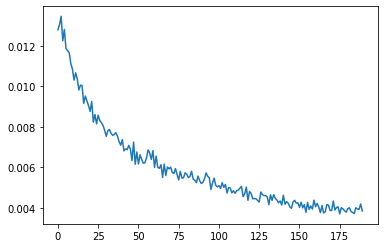

In [275]:
plt.plot(history.history['loss'][10:])

# Test 평가 

In [271]:
def descaling(value):
  origin = value*(csvs_output_max-csvs_output_min) + csvs_output_min
  return origin
def embedding(value):
  if value >=-1:
    return 0 
  else:
    return 1 
def score_metric(y_E_true,y_pred):
  from sklearn.metrics import confusion_matrix
  cm = confusion_matrix(y_E_true,y_pred)
  tp = cm[0][0]
  fn = cm[0][1]
  fp = cm[1][0]
  tn = cm[1][1]
  sensitivity = tp/(tp+fn)
  specificity = tn/(tn+fp)
  precision = tp/(tp+fp)
  acc = (tp+tn)/(tp+tn+fp+fn)
  print(f'Sensitivity = {sensitivity}')
  print(f'specificity = {specificity}')
  print(f'precision = {precision}')
  print(f'acc = {acc}')
  print(f'Confusion Matrix : \n{cm}')

  from sklearn.metrics import classification_report
  cr = classification_report(y_E_true,y_pred,target_names = ['0','1'])
  print(cr)

In [303]:
def make_prediction(model,train_index):
  import matplotlib.pyplot as plt 
  train_generator = DataGenerator(
                                key_lists[train_index],
                                output_column,
                                batch_size=BATCH_SIZE,
                                augmentation = False,
                                  shuffle=False)

  y_ = model.predict(train_generator)
  predicted = descaling(y_.squeeze())
  y_pred = pd.DataFrame(predicted)[0].map(embedding)
  y_true = csvs.iloc[train_index][output_column].values
  y_E_true = csvs.iloc[train_index]['E_'+output_column].values

  y_normal_index = np.where(y_E_true==0)[0]
  y_anormal_index = np.where(y_E_true==1)[0]
  score_metric(y_E_true,y_pred)

  plt.figure(figsize=(10,10))
  plt.title(f'{output_column} : Predicted Values Distribution')
  plt.hist(predicted[y_normal_index],alpha=0.5,label = 'normal')
  plt.hist(predicted[y_anormal_index],alpha=0.5,color='r',label = 'anormal')
  plt.axvline(-1,color='b',label = 'standard')
  plt.legend(fontsize = 'x-large')
  plt.show()

  import sklearn.metrics as metrics
  # calculate the fpr and tpr for all thresholds of the classification
  fpr, tpr, threshold = metrics.roc_curve(y_E_true,predicted)
  roc_auc = metrics.auc(fpr, tpr)

  # method I: plt
  import matplotlib.pyplot as plt
  plt.figure(figsize=(8,7))
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()
  return y_,predicted,y_pred

Sensitivity = 0.7651245551601423
specificity = 0.926829268292683
precision = 0.8884297520661157
acc = 0.8569230769230769
Confusion Matrix : 
[[430 132]
 [ 54 684]]
              precision    recall  f1-score   support

           0       0.89      0.77      0.82       562
           1       0.84      0.93      0.88       738

    accuracy                           0.86      1300
   macro avg       0.86      0.85      0.85      1300
weighted avg       0.86      0.86      0.86      1300



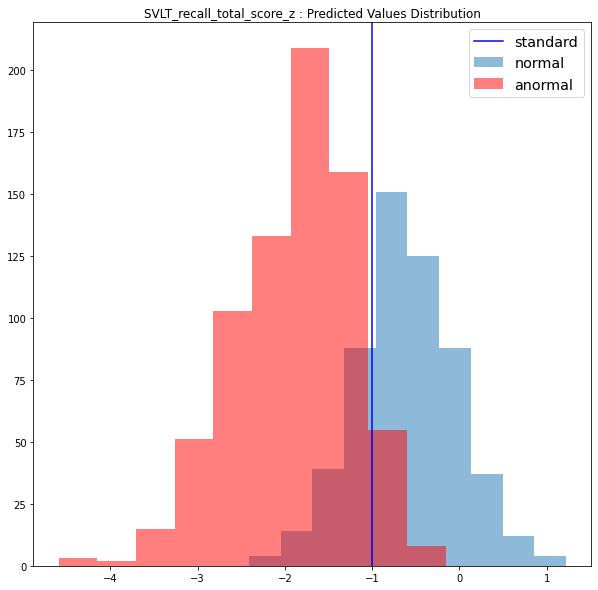

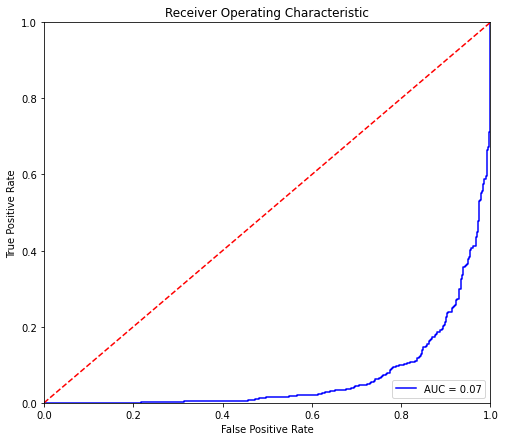

In [308]:
train_y_, train_predicted, train_y_pred = make_prediction(model,train_index)

Sensitivity = 0.43478260869565216
specificity = 0.7236842105263158
precision = 0.5882352941176471
acc = 0.5862068965517241
Confusion Matrix : 
[[30 39]
 [21 55]]
              precision    recall  f1-score   support

           0       0.59      0.43      0.50        69
           1       0.59      0.72      0.65        76

    accuracy                           0.59       145
   macro avg       0.59      0.58      0.57       145
weighted avg       0.59      0.59      0.58       145



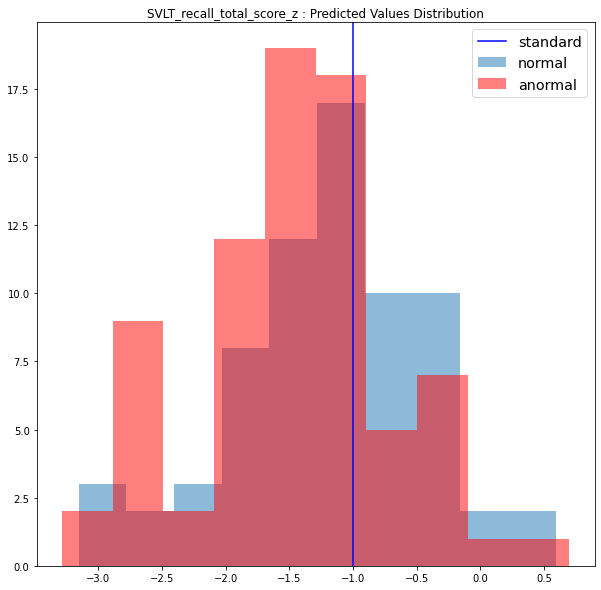

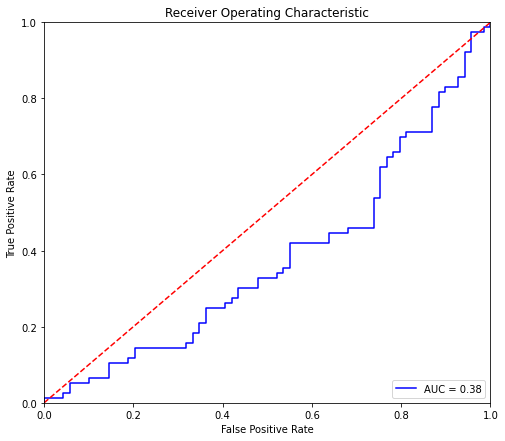

In [304]:
valid_y_, valid_predicted, valid_y_pred = make_prediction(model,valid_index)

Sensitivity = 0.4
specificity = 0.56
precision = 0.47619047619047616
acc = 0.48
Confusion Matrix : 
[[10 15]
 [11 14]]
              precision    recall  f1-score   support

           0       0.48      0.40      0.43        25
           1       0.48      0.56      0.52        25

    accuracy                           0.48        50
   macro avg       0.48      0.48      0.48        50
weighted avg       0.48      0.48      0.48        50



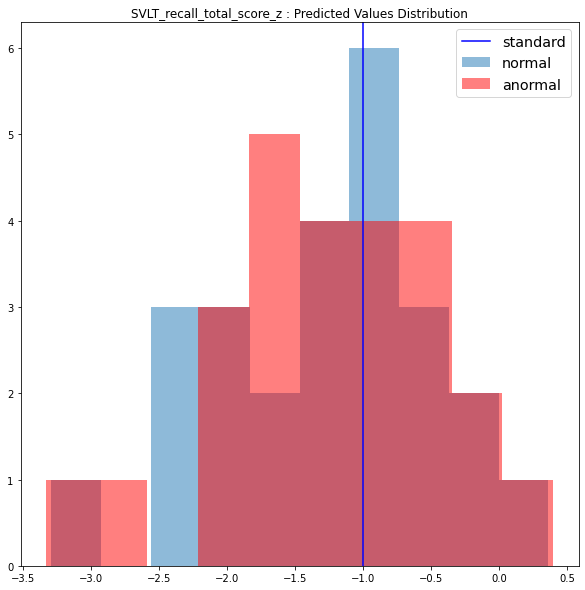

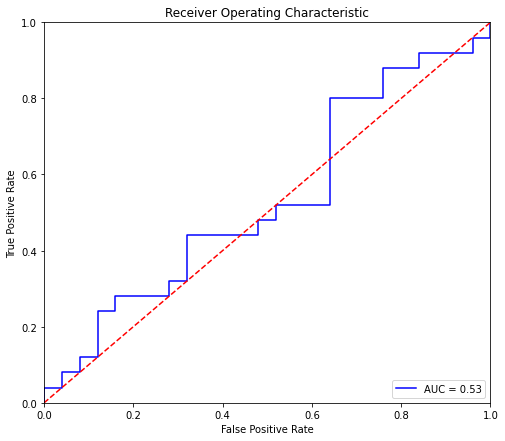

In [306]:
test_y_, test_predicted, test_y_pred = make_prediction(model,test_index[:50])

Sensitivity = 0.36
specificity = 0.639344262295082
precision = 0.45
acc = 0.5135135135135135
Confusion Matrix : 
[[18 32]
 [22 39]]
              precision    recall  f1-score   support

           0       0.45      0.36      0.40        50
           1       0.55      0.64      0.59        61

    accuracy                           0.51       111
   macro avg       0.50      0.50      0.50       111
weighted avg       0.50      0.51      0.50       111



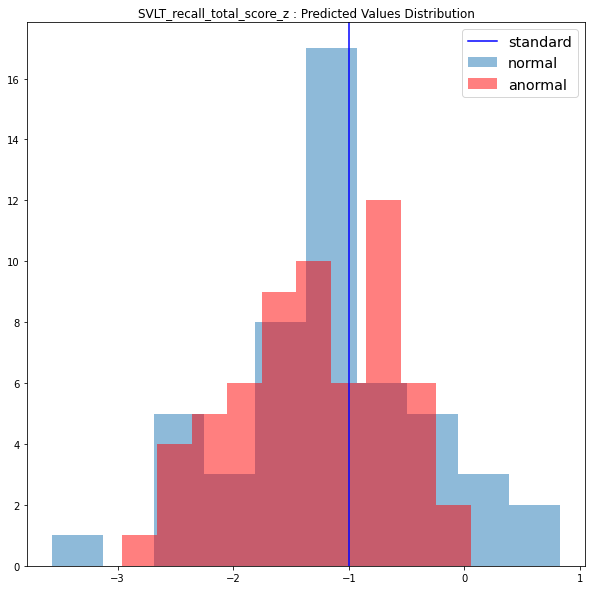

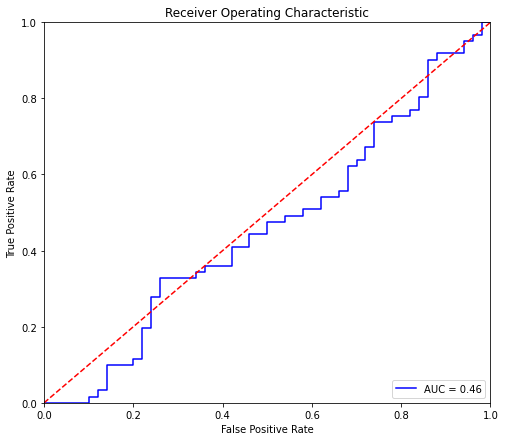

In [307]:
test_y_, test_predicted, test_y_pred = make_prediction(model,test_index[50:])